# BMI 551/651

# In-Class Example: Perceptrons

**Author:** Ben Cordier<br/>
**Date:** 11/17/19<br/>
**Quarter:** Winter 2020

Perceptron's are quite simple to implement. This notebook will walk you through the basics of coding a perceptron class in Python 3 using NumPy. 

The code is designed to be fairly extensible – it wouldn't be too much of a stretch to modify the code here to implement a single-layer neural network that allows for multiple activation functions, error functions, and some forms of regularization. 

### Imports & Setup
**NB**: This notebook uses several libraries and requires a system installation of GTK3 for the model training animations. To create the model training animations, uncomment the relevant lines in the cell below and in the last two code cells of this notebook. If you leave them commented, the notebook will still run.

### Dependencies
- `pandas`
- `numpy`
- `matplotlib`
- `seaborn`
- `celluloid` (Required for training animation)

All recent versions of these libraries should work. 

### Installation
To download the required dependencies, paste this into your terminal.

`pip install pandas numpy matplotlib seaborn celluloid`


In [663]:
# Inline Plotting
%matplotlib inline

# Math & Data Munging Imports
import numpy as np
import pandas as pd

# Visualization Imports
import matplotlib
# matplotlib.use('GTK3Agg') # UNCOMMENT THIS TO ALLOW (FASTER) ANIMATION RENDERING, REQUIRES OS INSTALLATION OF GTK3
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
import seaborn as sb

# Animation Imports
# from celluloid import Camera # UNCOMMENT THIS TO ALLOW ANIMATION

# Set Plotting Style
sb.set(style = "darkgrid")

# Set Random Seed
np.random.seed(1337)

# Perceptron

### Activation Function

First, let's define Rosenblatt's original activation function, signum – more commonly known as the sign function. 

In [664]:
def signum (product):
    return np.where(product >= 0, 1.0, -1.0)

### Error Functions

Let's define Rosenblatt's original error function. Recall that we only update the weights for training examples that were misclassified. We can include that in this function. 

In [665]:
# Rosenblatt's Error
def rosenblatt_error (self, classes, features):
    misclassified_classes = np.where(classes != self.outputs, np.subtract(classes, self.outputs), 0)
    error = np.dot(features.T, misclassified_classes)
    return error

### Weights Generation & Bias (Intercept)

Next, we need a weights generator. There are a number of things we can do here (weights initialization is an active area of deep learning research) – the simplest would be to start with `1` values. But we set a random seed using `np.random.seed` above, so why not just do random weights? 

We also will be adding a bias term into our features (with a value of 1.0) to generate an associated weight (this will hold the intercept of our function). While not strictly necessary, we'll define an `insert_bias` function for the sake of clarity.

If we were extending this to a neural network, for every training step and during prediction, we would have to insert a bias node for each hidden layer. 

In [666]:
# Weight Generation Function
def generate_weights(features):
    weights = np.random.normal(0, 1, (features.shape[1] + 1, 1)) # We Add 1 Here For Our Bias Term
    return weights

# Inserts a Bias Term (Intercept) Into Our Features
def insert_bias (features):
    m = features.shape[0]
    bias = np.ones(m).reshape(m, 1)
    return np.concatenate((bias, features), axis = 1)

### Training & Prediction Functions

And of course, the training and prediction functions.

In [667]:
# Training Function
def train (classes, features, weights = None, eta = 10e-3, batch_size = 1, epochs = 1):
    
    # Structure Classes & Features
    classes = classes[:, np.newaxis] # This Structures Our Classes Into a 2D Numpy.array
    features  = self.insert_bias(features)  # This Inserts a Bias Term (Intercept) Into Our Features

    # If No Weights Were Provided, Generate Them
    if weights is None:
        weights = generate_weights(features)

    # Epoch Loop
    for i in range(epochs):

        # Batch Loop
        for j in range((features.shape[0] // batch_size) + 1):

            # Generate Random Index & Grab A Random Minibatch
            indices = np.random.permutation(features.shape[0])
            classes = classes[indices[:, np.newaxis], np.arange(classes.shape[1])][0:batch_size]
            features = features[indices[:, np.newaxis], np.arange(features.shape[1])][0:batch_size]

            # Let's Classify Our Inputs
            outputs = signum(np.dot(features, weights))

            # And Compute Our Error
            errors = rosenblatt_error(classes, features)

            # Update Our Weights
            weights_delta = eta * errors
            weights_delta_total = np.sum(weights_delta, axis = 1)[:, np.newaxis] # Sum The Updates Across Entire Batch
            weights = weights + weights_delta_total
            
    # Return Trained Weights & Training History
    return weights

# Our Prediction Function
def predict (features, weights):
    features = insert_bias(features)
    outputs = signum(np.dot(features, weights))
    return outputs

# A Perceptron Class

Throwing it together we get the following Perceptron class. Note that I added in some functions to plot the decision boundary and animate the training. The `perceptron.history` attribute there to store the weights update at each training iteration. 

In [668]:
#!/usr/bin/python3

import numpy as np
from celluloid import Camera
import matplotlib.pyplot as plt

class Perceptron(object):
    """
    An Example of Rosenblatt's Perceptron for Binary Classification
    """
    def __init__(self,
        eta                         = 10e-3,
        epochs                      = 1,
        batch_size                  = 1,
        activation_function         = "signum",
        error_function              = "standard_error",
        weight_function             = "random_weights"
    ):
        # Set Attributes With Defaults
        self.eta                    = eta
        self.epochs                 = epochs
        self.batch_size             = batch_size
        self.activation_function    = activation_function
        self.error_function         = error_function
        self.weight_function        = weight_function
        
        # Other References (Initalized During Training)
        self.classes                = None
        self.features               = None
        self.errors                 = None
        self.outputs                = None
        self.weights                = None
        self.history                = None
    
    #
    # Activation Function
    #
    
    # Signum Activation
    def signum (self, product):
        return np.where(product >= 0, 1.0, -1.0)
    
    #
    # Weight Initializer
    #
    
    # Random Weights Initializer
    def random_weights(self, features):
        weights = np.random.normal(0, 1, (features.shape[1] + 1, 1)) # We Add 1 Here For Our Bias Term
        return weights
    
    #
    # Error Function
    #
    
    # Rosenblatt's Error
    def rosenblatt_error (self, classes, features):
        misclassified_classes = np.where(classes != self.outputs, classes - self.outputs, 0)
        error = np.dot(features.T, misclassified_classes)
        return error
    
    #
    # Model Helper Methods
    #
    
    # Inserts a Bias Term (Intercept) Into Our Features
    def insert_bias (self, features):
        n = features.shape[0]
        bias = np.ones(n).reshape(n, 1)
        return np.concatenate((bias, features), axis = 1)
    
    # Classifies Our Example(s)
    def classify (self, features, weights):
        return getattr(self, self.activation_function)(np.dot(features, weights))
        
    #
    # Model Methods
    #
        
    # Our Training Function
    def train(self,
        classes,
        features,
        weights                     = None,
        eta                         = None,
        epochs                      = None,
        batch_size                  = None,
        activation_function         = None,
        error_function              = None,
        weight_function             = None
    ):
        # Assign Our Classes & Features to The Perceptron
        self.classes                = classes[:, np.newaxis] # This Structures Our Classes Into a 2D Numpy.array
        self.features               = self.insert_bias(features)  # This Inserts a Bias Term (Intercept) Into Our Features
        # If We've Received Values For These, Assign Them, Otherwise Use Default Init Values
        self.eta                    = eta                   if eta                  is not None else self.eta
        self.epochs                 = epochs                if epochs               is not None else self.epochs
        self.batch_size             = batch_size            if batch_size           is not None else self.batch_size
        self.activation_function    = activation_function   if activation_function  is not None else self.activation_function
        self.error_function         = error_function        if error_function       is not None else self.error_function
        self.weight_function        = weight_function       if weight_function      is not None else self.weight_function
        # Init Training History
        self.history = []
        
        # Let's Generate Our Weights
        if weights is None:
            weights = getattr(self, self.weight_function)(features)
            self.history.append(weights)
            self.weights = weights
        
        # Epoch Loop
        for i in range(self.epochs):
            
            # Sample Loop
            for j in range((self.features.shape[0] // self.batch_size) + 1):
                
                # Generate Random Index & Grab A Random Minibatch
                indices = np.random.permutation(self.features.shape[0])
                classes = self.classes[indices[:, np.newaxis], np.arange(self.classes.shape[1])][0:self.batch_size]
                features = self.features[indices[:, np.newaxis], np.arange(self.features.shape[1])][0:self.batch_size]
                
                # Now Let's Call Our Classification Function & Compute Our Error
                self.outputs = self.classify(features, self.weights)
                self.errors = getattr(self, self.error_function)(classes, features)
                
                # Update Our Weights
                weights_delta = self.eta * self.errors
                weights_delta_total = np.sum(weights_delta, axis = 1)[:, np.newaxis] # Sum The Updates Across Entire Batch
                self.weights = self.weights + weights_delta_total

                # Update Our Training History
                self.history.append(self.weights)
                
        return self
    
    # Our Prediction Function (For Both Validation & Prediction)
    def predict (self, features):
        features = self.insert_bias(features)  # This Inserts a Bias Term (Intercept) Into Our Features
        return self.classify(features, self.weights)
    
    #
    # Visualization Methods
    #
    
    # Method For Visualizing Training - Relies on Celluloid Library For Animation
    def visualize_training (self, 
        df, 
        label,
        features, 
        history = [],
        resolution = 0.01, 
        interval = 2, 
        blit = True, 
        loop = False
    ):
        
        # Use History Attribute if Not History Is Provided
        history = history if len(history) > 0 else self.history
        # Get Classes & Features, Insert Bias Term
        classes, features = df[[label]].values[:,0], df[features].values

        # Setup Plotting
        plt.figure(figsize = (12, 12))
        fig, ax = plt.subplots()
        camera = Camera(fig)    
        
        # Replay Training
        for weights in history:

            # Visualize Decision Boundary
            x1, x2 = self.get_decision_boundary()
            ax.plot(x1, x2)
            # Plot Data Points
            ax.scatter(features[:,0], features[:,1], c = classes, alpha = 0.6, cmap = plt.cm.Dark2)
            
            # Save Animation Frame
            camera.snap()
        
        # Generate Animation
        animation = camera.animate(interval = interval, blit = blit, repeat = loop)

        return animation
    
    # Method For Visualizing Decision Boundary of Trained Perceptron
    def visualize_decision_boundary (self, 
        df, 
        label, 
        features, 
        resolution = 0.01
    ):
        
        # Get Classes & Features, Insert Bias Term
        classes, features = df[[label]].values[:,0], df[features].values

        # Setup Plotting
        fig, ax = plt.subplots(figsize = (12, 12))   
        # Visualize Decision Boundary
        x1, x2 = self.get_decision_boundary()
        ax.plot(x1, x2)
        # Plot Data Points
        ax.scatter(features[:,0], features[:,1], c = classes, cmap = plt.cm.Dark2)
        
        return fig, ax
    
    #
    # Visualization Helper Methods
    #

    # Extract out the decision boundary for the trained model
    def get_decision_boundary (self):
        w0, w1, w2 = self.weights
        xDomainMax = np.max(features[:, 0])
        decision_boundary = (np.linspace(0, xDomainMax, xDomainMax + 1), (np.linspace(0, xDomainMax, xDomainMax + 1) * (w1 / -w2)) + (w0 / -w2))
        return decision_boundary

### Caveats
Importantly, the `perceptron.get_decision_boundary` function only works for data sets with two features. It's only required here for this example; besides, once you get past three features, how are you going to visualize the decision boundary?

## Test Drive
Time to take the perceptron for a test drive. We'll start by simulating some data and plotting our the distributions of the features. Next, we'll train the perceptron using the different training regimes. Okay, let's go!

### Data Simulation
The method below takes in as parameters the number of classes (`nclasses`), number of samples for each class (`nsamples`), and number of features (`nfeatures`); it returns simulated data as a `DataFrame`. While the data frames nice for plotting, we'll pass in a `numpy.ndarray` into our perceptron code by extracting the numpy array from Pandas `DataFrame.values`. This let's us do broadcasting, which, in addition to making our code run faster, helps our code look a smidge more like the math upon which the perceptron is based. 

In [669]:
# Data Generation Function. The Data Generated is For Illustrative Purposes Only, Not Design For Benchmarking Models, Approaches, Etc.
def simulate_data (nclasses = 2, nsamples = 3, nfeatures = 3):
    data = None
    colnames = ["y"] + ["x%d" % i for i in range(nfeatures)]
    distributionparams = [(np.random.randint(3,5), np.random.randint(1, 2)) for i in range(nfeatures)]
    for k in range(nclasses):
        classlabel = -1 if k == 0 else 1
        examples = [np.linspace(classlabel, classlabel, nsamples)] # Generate Class Vector
        for f in range(nfeatures):
            mean, stdev = distributionparams[f]
            examples.append((k + 1) * np.random.normal(mean, stdev, nsamples)) # Generate a Distribution For Each Feature That Differs by Class
        kdata = np.array(examples).T
        data = kdata if data is None else np.vstack((data, kdata))
    np.random.shuffle(data)
    data = pd.DataFrame(data, columns = colnames)
    return data

### Simulated Data

In [670]:
# Let's Simulate Our Data & Plot The Distributions of Each Feature
nclasses, nsamples, nfeatures, split = 2, 300, 2, 0.8
df = simulate_data(nclasses, nsamples, nfeatures)
traindf, validdf = df.iloc[:int(nsamples * split), :], df.iloc[int(nsamples * split):, :]

# How Does The Train DataFrame Look?
traindf.describe()

,y,x0,x1
count,240.000000,240.000000,240.000000
mean,0.016667,6.026800,6.032772
std,1.001951,2.484238,2.724952
min,-1.000000,1.524935,1.278110
25%,-1.000000,4.122821,3.847401
50%,1.000000,5.642511,5.045867
75%,1.000000,7.878049,8.288825
max,1.000000,12.202612,13.274596


In [671]:
# And The Validation DataFrame?
validdf.describe()

,y,x0,x1
count,360.000000,360.000000,360.000000
mean,-0.011111,6.056246,5.983089
std,1.001330,2.488105,2.516317
min,-1.000000,1.847298,1.539096
25%,-1.000000,4.148338,3.918190
50%,-1.000000,5.269198,5.169005
75%,1.000000,8.012517,7.961228
max,1.000000,14.027160,12.866771


The distributions between the training and validation sets are pretty close – good! Notice that while we don't have a perfect class balance (see the mean of `y` – ideally, with a `+1` and `-1` representing our two classes it should be `0`) but it should be close enough.

### Plotting Our Simulated Data

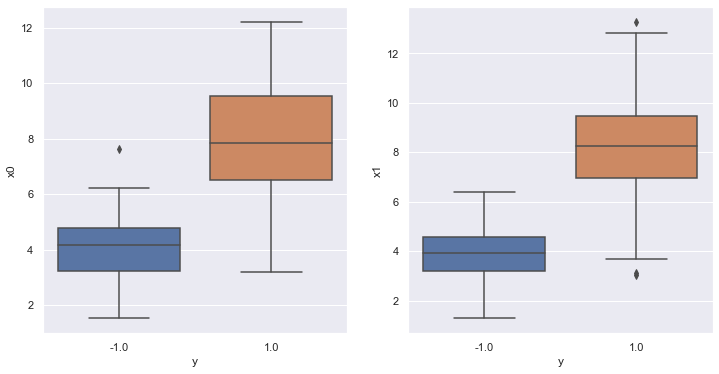

In [672]:
# Plotting
plt.figure(figsize = (12, 6))
gs = grd.GridSpec(1, 2)
for i in range(nfeatures):
    plt.subplot(gs[0, i])
    sb.boxplot(x = "y", y = "x%d" % i , data = traindf)

### Training Our Perceptron Models

We're ready to train our perceptron. We'll use two different training regimes: batch gradient descent and stochastic gradient descent. Provided that our data is linearly separable, batch gradient descent (BGD) converges to the global optimum as our batch size approaches the number of examples in our data set.

Stochastic gradient descent (SGD) can be done in two forms using either mini batches (with a batch size of, say, 30 examples) or individual examples. While SGD does not guarantee have a global optimum guarantee, the local approximations are generally very good.

When it comes to training any machine learning model, it can be instructive to visualize the decision boundary of the model as training progresses. Good news: We can do this quite easily (see the method `Perceptron.visualize_training` to get an idea of how). Bad news: It takes a while because matplotlib is not the greatest in terms of animation and time/memory efficiency. To speed it up a smidge, we can use GTK3 as our back-end but, even so, it'll still take a few minutes.

In [673]:
#
# Model Training 
#

# Let's Extract Out Our Classes & Features From The DataFrame
classes, features = traindf.values[:,0], traindf.values[:,1:]

# Initialize Our Perceptron
perceptron = Perceptron(error_function = "rosenblatt_error")

# Train Perceptron - Batch Gradient Descent (BGD)
perceptron.train(classes, features, eta = 2e-1, batch_size = classes.shape[0], epochs = 500)
weights_bgd = perceptron.weights # Extract Weights
history_bgd = perceptron.history # Extract History

# Train Perceptron - Stochastic Gradient Descent (SGD)
perceptron.train(classes, features, eta = 2e-1, batch_size = 1, epochs = 10)
weights_sgd = perceptron.weights # Extract Weights
history_sgd = perceptron.history # Extract History

### Model Validation & Visualization

Perceptron (BGD), 500 Epochs; Validation Accuracy: 98.06%


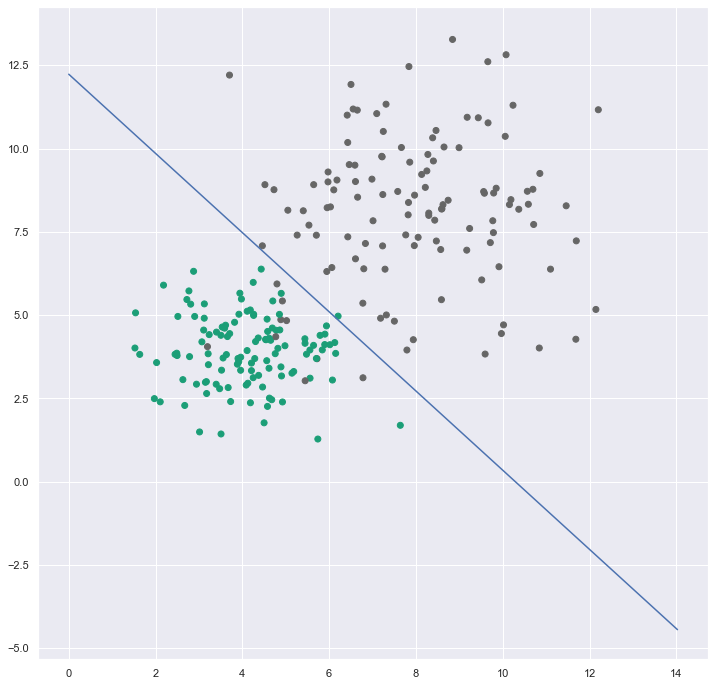

In [674]:
# Validation Data
classes, features = validdf.values[:,0], validdf.values[:,1:]

#
# Validation - BGD
#

# Load BGD Model Weights
perceptron.weights = weights_bgd

# Predict
predictions = perceptron.predict(features)

# Compute & Print Accuracy
accuracy = np.subtract(1.0, np.sum(np.abs(np.subtract(classes, predictions.flatten()))) / 2.0 / predictions.shape[0]) * 100

#
# Visualization - BGD
#

# Visualize Final Decision Boundary
print("Perceptron (BGD), 500 Epochs; Validation Accuracy: %0.2f%%" % accuracy)
boundary_visualization = perceptron.visualize_decision_boundary(traindf, "y", ["x0", "x1"])

#
# Uncomment code below to save an animation (GIF) of the BGD training
# 

# # Visualize The Training
# train_visualization = perceptron.visualize_training(traindf, "y", ["x0", "x1"], history = history_bgd)

# # Save Visualization
# train_visualization.save("perceptron_training_bgd.gif", writer = 'imagemagick')

#### Training - Stochastic Gradient Descent

Perceptron (SGD), 5 Epochs; Validation Accuracy: 97.50%


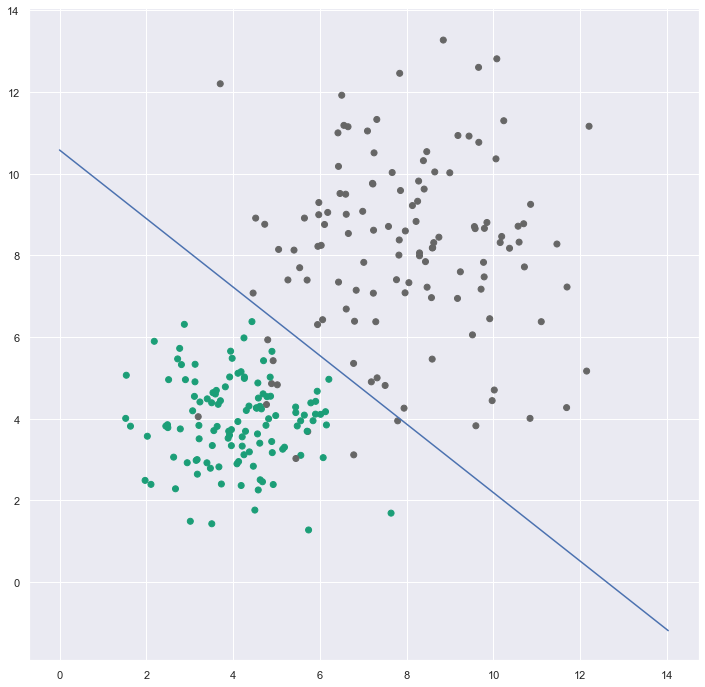

In [675]:
#
# Validation - SGD
#

# Load BGD Model Weights
perceptron.weights = weights_sgd

# Predict
predictions = perceptron.predict(features)

# Compute & Print Accuracy
accuracy = np.subtract(1.0, np.sum(np.abs(np.subtract(classes, predictions.flatten()))) / 2.0 / predictions.shape[0]) * 100

#
# Visualization - SGD
#

# Visualize Final Decision Boundary
print("Perceptron (SGD), 5 Epochs; Validation Accuracy: %0.2f%%" % accuracy)
boundary_visualization = perceptron.visualize_decision_boundary(traindf, "y", ["x0", "x1"])

#
# Uncomment code below to save an animation (GIF) of the SGD training
# 

# # Visualize The Training
# train_visualization = perceptron.visualize_training(traindf, "y", ["x0", "x1"], history = history_sgd)

# # Save Visualization
# train_visualization.save("perceptron_training_bgd.gif", writer = 'imagemagick')